In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
tf.__version__

2024-03-31 17:30:53.843396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 17:30:53.843496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 17:30:53.977400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

In [2]:
import keras
keras.__version__

'3.0.5'

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [4]:
directory = r'/kaggle/input/project-final/IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin', 'Malignant', 'Normal']

In [5]:
#Image Size Variations
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

/tmp/ipykernel_34/3859160570.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Bengin': {'640 x 640': 316},
 'Malignant': {'640 x 640': 878},
 'Normal': {'640 x 640': 1003}}

Bengin


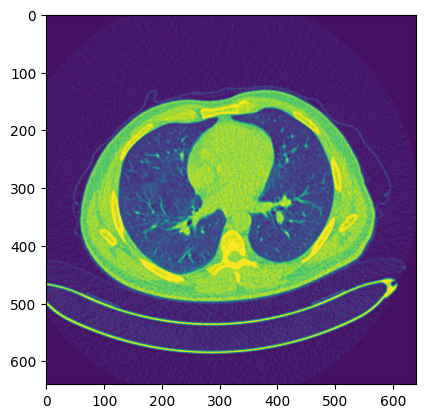

Malignant


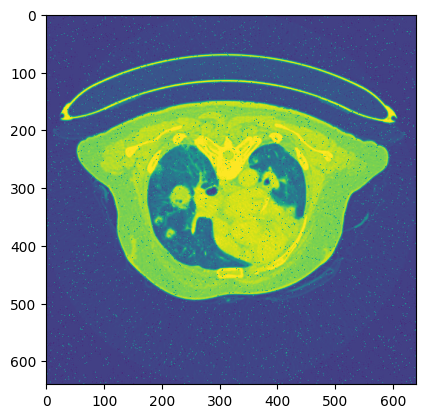

Normal


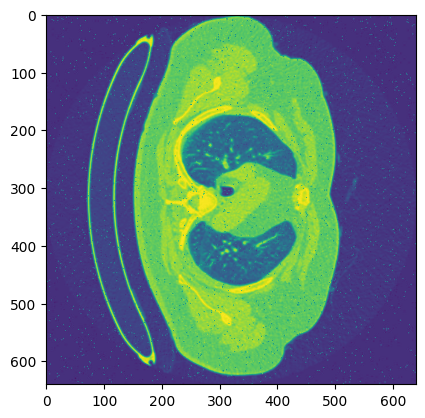

In [6]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

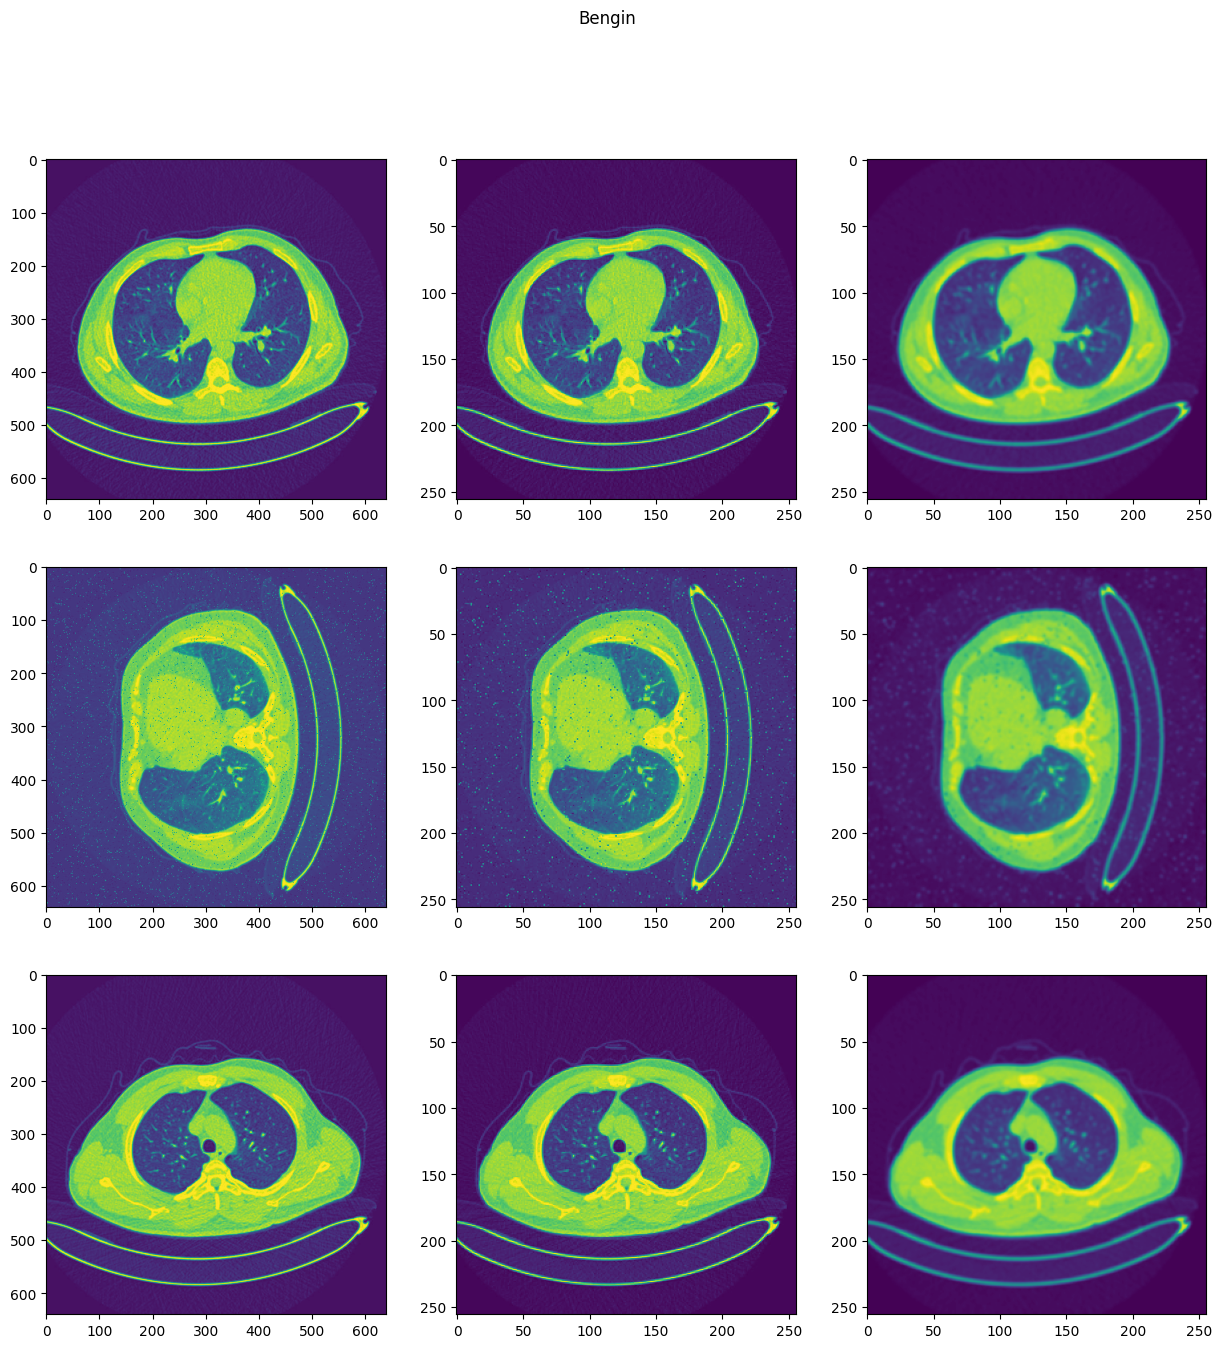

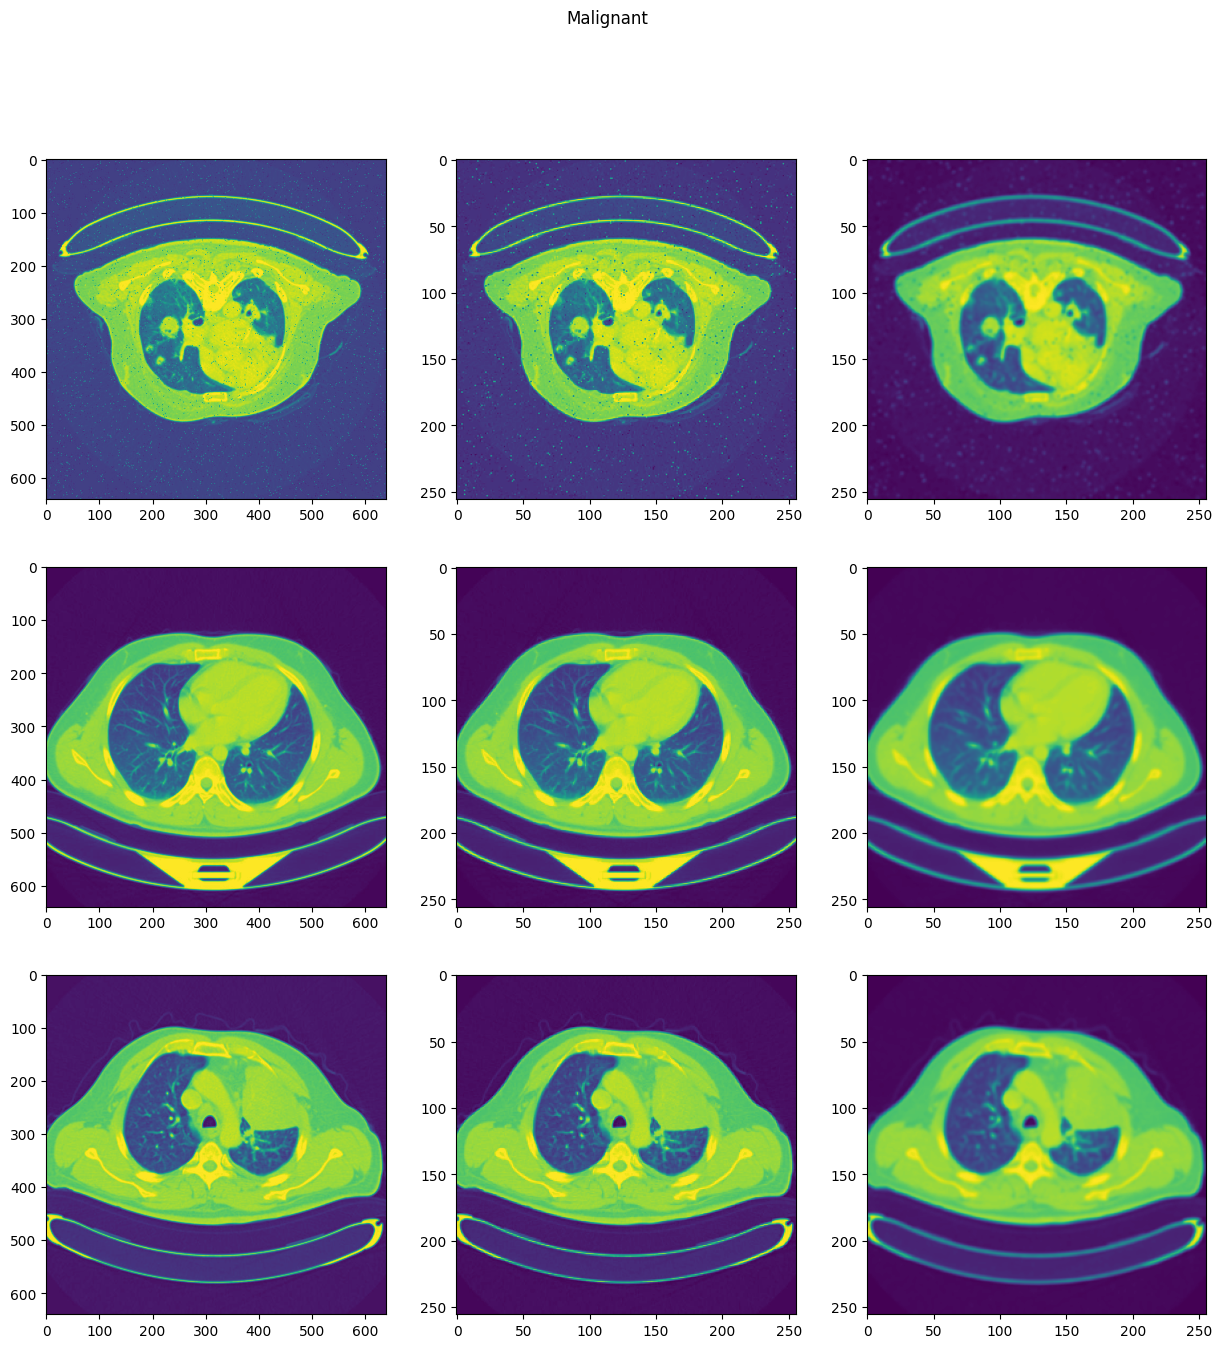

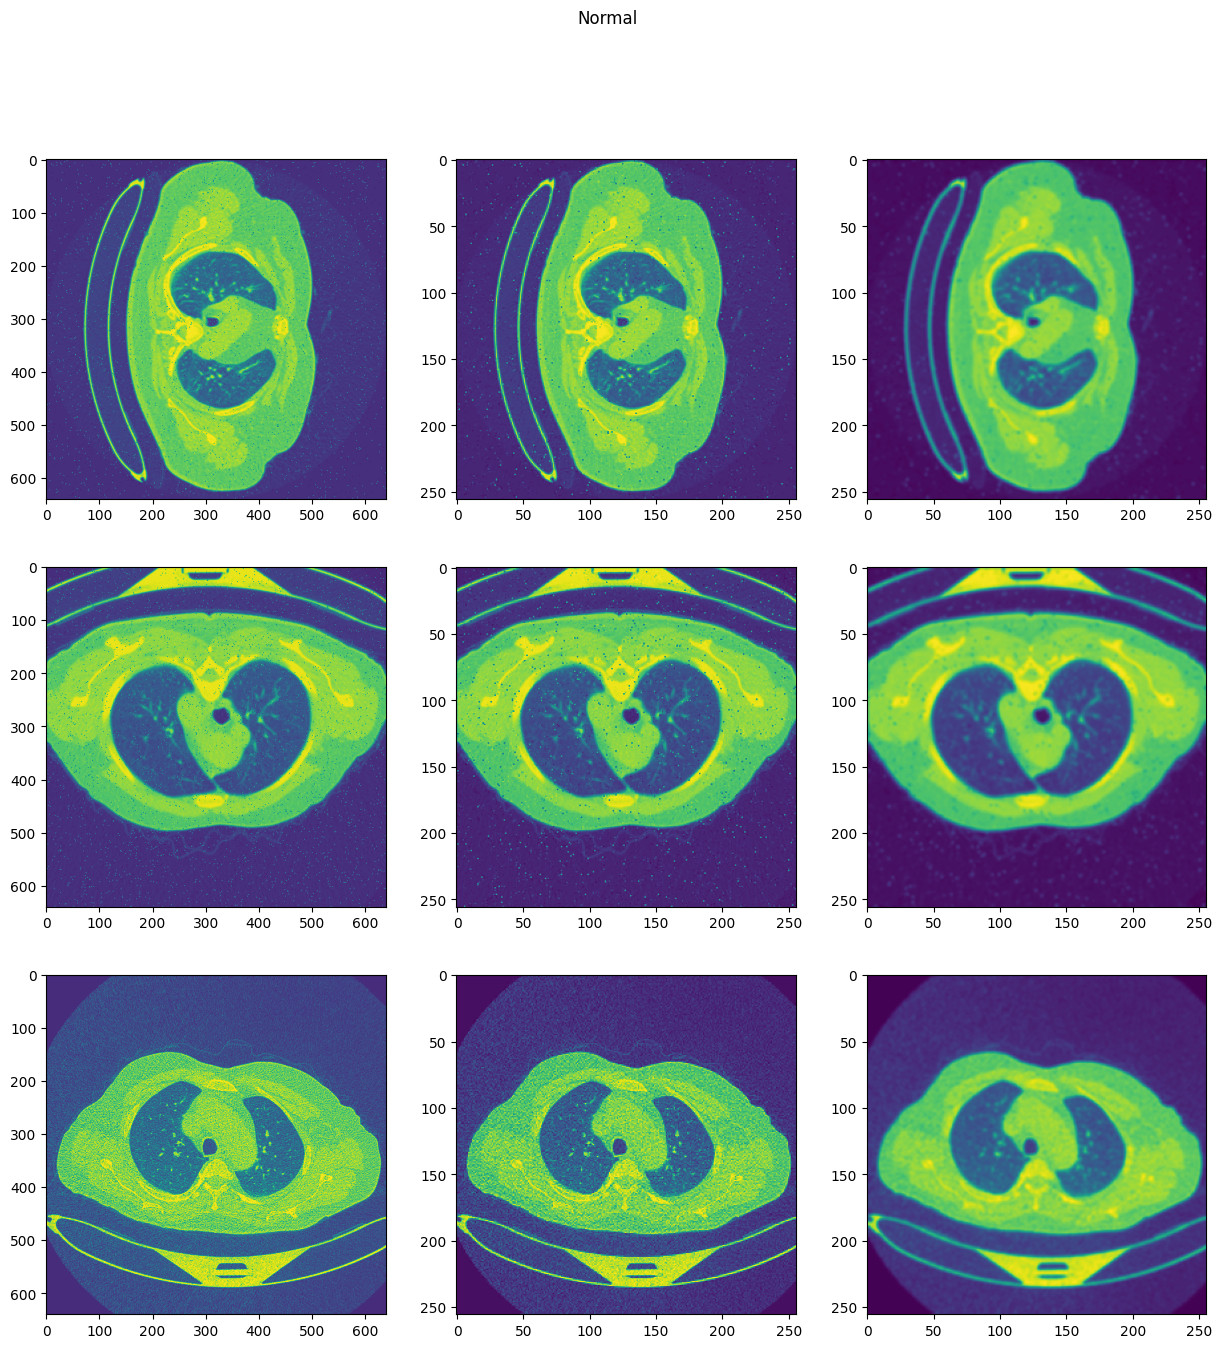

In [7]:
#Image Preprocessing and Testing

img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()

In [8]:
#Preparing data
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))


# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 2197
y counts: Counter({2: 1003, 1: 878, 0: 316})


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

1647 (1647, 256, 256, 1)
550 (550, 256, 256, 1)


In [10]:
#Applying SMOTE to oversample the data

print(Counter(y_train), Counter(y_valid))

Counter({2: 752, 1: 658, 0: 237}) Counter({2: 251, 1: 220, 0: 79})


In [11]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

1647 (1647, 256, 256, 1)
1647 (1647, 65536)


In [12]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({2: 752, 1: 658, 0: 237})
After SMOTE: Counter({1: 752, 2: 752, 0: 752})


In [13]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

1647 (1647, 256, 256, 1)
2256 (2256, 256, 256, 1)


In [14]:
#Model Building with SMOTE data

model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(3, activation='softmax'))

model1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 254, 254, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │     3,936,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,973,891 (15.16 MB)

 Trainable params: 3,973,891 (15.16 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
history = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
 10/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.2836 - loss: 7.1676

I0000 00:00:1711907145.895169     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711907145.911808     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4352 - loss: 1.6367

W0000 00:00:1711907151.770086     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.4369 - loss: 1.6296 - val_accuracy: 0.7764 - val_loss: 0.5474
Epoch 2/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9090 - loss: 0.2569 - val_accuracy: 0.8509 - val_loss: 0.4483
Epoch 3/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9785 - loss: 0.0860 - val_accuracy: 0.8545 - val_loss: 0.5061
Epoch 4/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9909 - loss: 0.0338 - val_accuracy: 0.8527 - val_loss: 0.5577
Epoch 5/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9886 - loss: 0.0400 - val_accuracy: 0.8800 - val_loss: 0.5797
Epoch 6/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9987 - loss: 0.0068 - val_accuracy: 0.8782 - val_loss: 0.5891
Epoch 7/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9983 - loss: 0.0233 - val_accuracy: 0.8745 - val_loss: 0.6182
Epoch 8/15
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9992 - loss: 0.0037 - val_accuracy: 0.87

In [17]:
#Results
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        79
           1       0.92      0.89      0.90       220
           2       0.87      0.93      0.90       251

    accuracy                           0.89       550
   macro avg       0.88      0.86      0.87       550
weighted avg       0.89      0.89      0.89       550

[[ 59   7  13]
 [  4 195  21]
 [  7  10 234]]


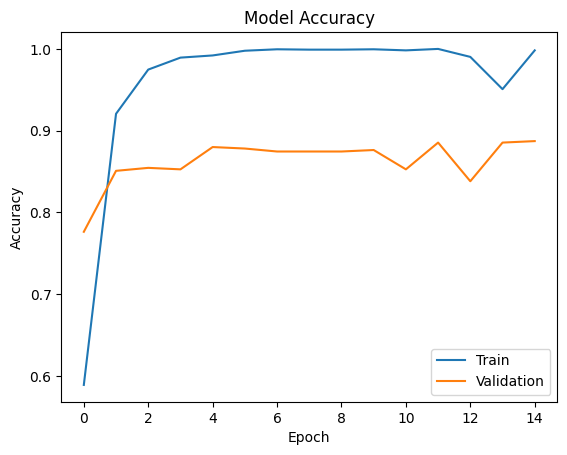

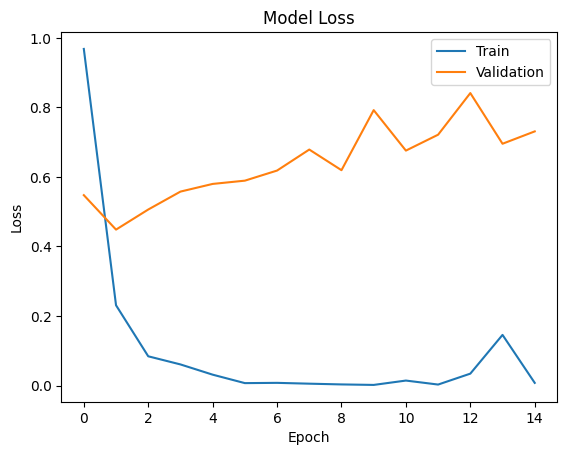

In [18]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
#Model Building with Class Weighted Approach

model2 = Sequential()

model2.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(16))
model2.add(Dense(3, activation='softmax'))

model2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 254, 254, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │     3,936,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,973,891 (15.16 MB)

 Trainable params: 3,973,891 (15.16 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train)[0]),
    1: X_train.shape[0]/(3*Counter(y_train)[1]),
    2: X_train.shape[0]/(3*Counter(y_train)[2]),
}

# new_weights[0] = 0.5
# new_weights[1] = 20

new_weights

{0: 2.3164556962025316, 1: 0.8343465045592705, 2: 0.7300531914893617}

In [22]:
history = model2.fit(X_train, y_train, batch_size=8, epochs=10, validation_data=(X_valid, y_valid), class_weight=new_weights)

Epoch 1/10
  7/206 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3958 - loss: 6.2860

W0000 00:00:1711907382.339044     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3111 - loss: 1.7127

W0000 00:00:1711907391.226586     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


206/206 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.3114 - loss: 1.7102 - val_accuracy: 0.4945 - val_loss: 0.9677
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7012 - loss: 0.6884 - val_accuracy: 0.7764 - val_loss: 0.5416
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8989 - loss: 0.2785 - val_accuracy: 0.8400 - val_loss: 0.5216
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9697 - loss: 0.1046 - val_accuracy: 0.8855 - val_loss: 0.4382
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9871 - loss: 0.0512 - val_accuracy: 0.8964 - val_loss: 0.4688
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9937 - loss: 0.0216 - val_accuracy: 0.8909 - val_loss: 0.5260
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9941 - loss: 0.0261 - val_accuracy: 0.8745 - val_loss: 0.5259
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9985 - loss: 0.0153 - val_accuracy: 0.89

In [23]:
#Results

y_pred = model2.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
              precision    recall  f1-score   support

           0       0.91      0.73      0.81        79
           1       0.90      0.90      0.90       220
           2       0.87      0.92      0.90       251

    accuracy                           0.89       550
   macro avg       0.89      0.85      0.87       550
weighted avg       0.89      0.89      0.88       550

[[ 58   8  13]
 [  2 197  21]
 [  4  15 232]]


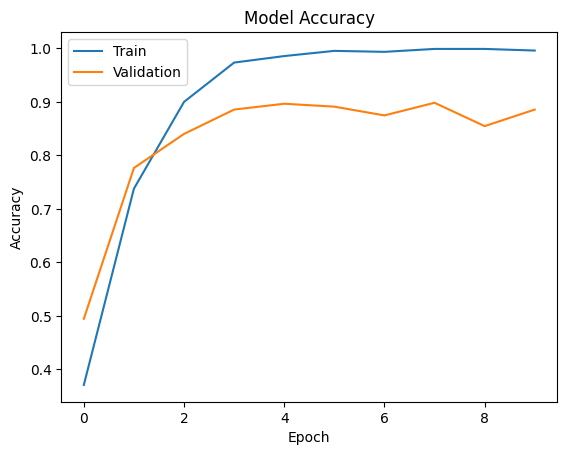

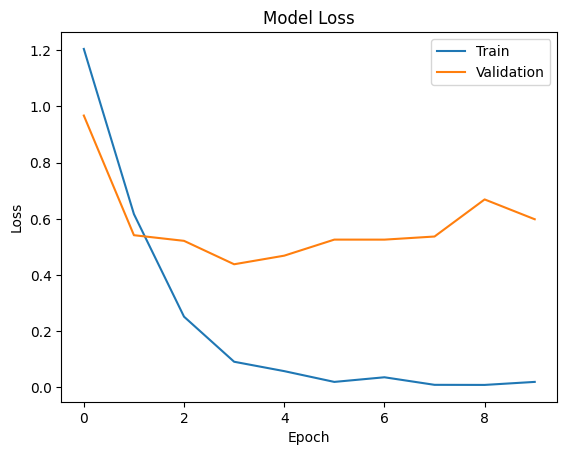

In [24]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [25]:
#Data Augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True) 
val_datagen = ImageDataGenerator()

In [26]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8) 
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

In [27]:
X_train.shape[1:]

(256, 256, 1)

In [28]:
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(16))
model3.add(Dense(3, activation='softmax'))

model3.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 254, 254, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │     3,936,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,973,891 (15.16 MB)

 Trainable params: 3,973,891 (15.16 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
history = model3.fit(train_generator, epochs=10, validation_data=val_generator, class_weight=new_weights)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  7/206 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.3809 - loss: 10.0462

W0000 00:00:1711907506.487684     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3563 - loss: 2.3017

W0000 00:00:1711907511.434808     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.3565 - loss: 2.2925 - val_accuracy: 0.5927 - val_loss: 0.9525
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6482 - loss: 0.8833 - val_accuracy: 0.7582 - val_loss: 0.6222
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7931 - loss: 0.5697 - val_accuracy: 0.7964 - val_loss: 0.5689
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8635 - loss: 0.3321 - val_accuracy: 0.8855 - val_loss: 0.3390
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9371 - loss: 0.2029 - val_accuracy: 0.8891 - val_loss: 0.2780
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9324 - loss: 0.2064 - val_accuracy: 0.9291 - val_loss: 0.2410
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9668 - loss: 0.1012 - val_accuracy: 0.9291 - val_loss: 0.2221
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9616 - loss: 0.1121 - val_accuracy: 0.938

In [31]:
X_valid.shape

(550, 256, 256, 1)

In [32]:
y_pred = model3.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        79
           1       0.97      0.97      0.97       220
           2       0.97      0.93      0.95       251

    accuracy                           0.94       550
   macro avg       0.91      0.94      0.92       550
weighted avg       0.95      0.94      0.94       550

[[ 72   0   7]
 [  6 213   1]
 [ 12   6 233]]


In [33]:
model3.save("cancermodel.keras")

In [34]:
model3.save("cancermodel.h5")

In [35]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the saved model
model = load_model('cancermodel.keras')

In [36]:
# Function to load and preprocess the image
def load_and_preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size, color_mode='grayscale')  # Convert to grayscale
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to display the image and its predicted label
def display_prediction(image_path, model, class_names):
    img = load_and_preprocess_image(image_path, target_size=(256, 256))  # Adjust target_size based on your model's input shape
    prediction = model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]
    plt.imshow(Image.open(image_path).convert('L'), cmap='gray')  # Display the grayscale image
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


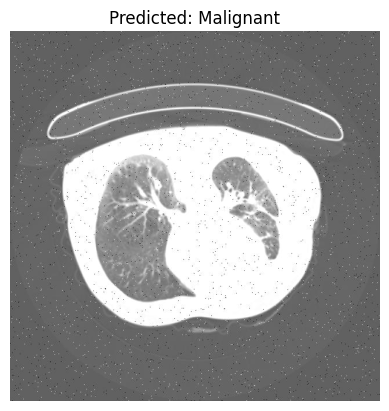

In [37]:
# Example usage
image_path = '/kaggle/input/project-final/IQ-OTHNCCD lung cancer dataset/Malignant/Malignant-case-1-_jpg.rf.7aa4f69a52606f8e14ab2dc85d7e9852.jpg'  # Replace with the path to your image
class_names = ['Bengin', 'Malignant', 'Normal']  # Replace with your actual class names
display_prediction(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


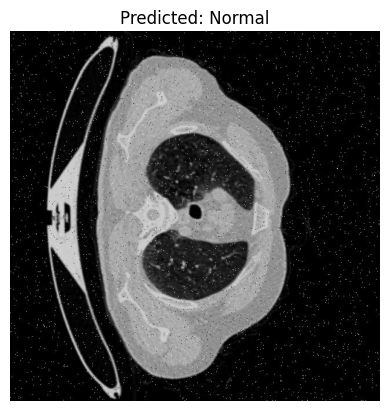

In [38]:
# Example usage
image_path = '/kaggle/input/project-final/IQ-OTHNCCD lung cancer dataset/Normal/1_jpg.rf.0402a13c99b70c1e4ee1a7cdbbece3fb.jpg'  # Replace with the path to your image
class_names = ['Bengin', 'Malignant', 'Normal']  # Replace with your actual class names
display_prediction(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


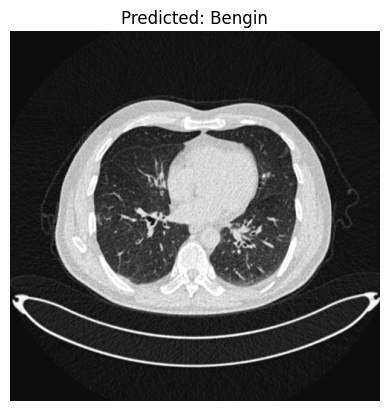

In [39]:
image_path = '/kaggle/input/project-final/IQ-OTHNCCD lung cancer dataset/Bengin/Bengin-case-10-_jpg.rf.405c90be653f614438256a3c4fcd643e.jpg'  # Replace with the path to your image
class_names = ['Bengin', 'Malignant', 'Normal']  # Replace with your actual class names
display_prediction(image_path, model, class_names)